# Transfer Learning for Plant Disease Detection

This notebook demonstrates how to use transfer learning for image detection. We will cover the following steps:

- Enviornment Setup and Library Imports
- Data loading and exploration
- Extensive data preprocessing and augmentation
- Building a transfer learning model
- Training and evaluating the model


## 1. Environment Setup and Library Imports

First, we import all necessary libraries. We use TensorFlow/Keras for building and training our model and various utility libraries for data handling and visualization.


In [2]:
# Import essential libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import datetime
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


# Check TensorFlow version and available GPUs
print("TensorFlow version:", tf.__version__)
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

# Set seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

TensorFlow version: 2.19.0
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2️⃣ Enable Mixed Precision Training

- Enable mixed precision


In [3]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')
print("Mixed Precision Enabled: ", tf.keras.mixed_precision.global_policy())

Mixed Precision Enabled:  <DTypePolicy "mixed_float16">


## **SECTION 2: DATA LOADING & PREPROCESSING**

In this section, we assume that you have a single directory called `color` which contains subdirectories for each plant class. We will:

1. check for corrupted images
2. Use `ImageDataGenerator` to automatically split the dataset into training (80%) and validation (20%).
3. Apply data augmentation to make the model more robust.
4. Display sample images to confirm the data loading process.


In [3]:
# check for corrupted images
import os
from PIL import Image

dataset_path = "dataset/color"

for root, _, files in os.walk(dataset_path):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            img = Image.open(file_path)  # Try opening the image
            img.verify()  # Check for corruption
        except (IOError, SyntaxError) as e:
            print(f"Corrupted image: {file_path}")

Corrupted image: dataset/color/Bell_pepper___healthy/65918.jpg
Corrupted image: dataset/color/Bell_pepper___healthy/66018.jpg
Corrupted image: dataset/color/Bell_pepper___healthy/65902.jpg
Corrupted image: dataset/color/Bell_pepper___healthy/66048.jpg
Corrupted image: dataset/color/Bell_pepper___healthy/66098.jpg
Corrupted image: dataset/color/Bell_pepper___healthy/65997.jpg
Corrupted image: dataset/color/Bell_pepper___healthy/65942.jpg
Corrupted image: dataset/color/Bell_pepper___healthy/66002.jpg
Corrupted image: dataset/color/Bell_pepper___healthy/66134.jpg
Corrupted image: dataset/color/Bell_pepper___healthy/65896.jpg
Corrupted image: dataset/color/Bell_pepper___healthy/65963.jpg
Corrupted image: dataset/color/Bell_pepper___healthy/65895.jpg
Corrupted image: dataset/color/Bell_pepper___healthy/65984.jpg
Corrupted image: dataset/color/Bell_pepper___healthy/65965.jpg
Corrupted image: dataset/color/Bell_pepper___healthy/65947.jpg
Corrupted image: dataset/color/Bell_pepper___healthy/66

In [ ]:
# Path to your dataset folder (contains subfolders for each class)
DATA_DIR = "dataset/color"


# Image dimensions and batch size

IMG_HEIGHT, IMG_WIDTH = 224, 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)

BATCH_SIZE = 32

VALIDATION_SPLIT = 0.3  # 30% for validation, i.e., 70:30 split
SEED = 123

# Load training dataset (70% of data)
train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VALIDATION_SPLIT,
    subset="training"  # Training subset gets 70%
)


validation_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VALIDATION_SPLIT,
    subset="validation"  # Validation subset gets 30%

)


# Get the class names (it will be inferred from the subfolder names)

class_names = train_dataset.class_names
print("Classes:", class_names)
num_categories = len(class_names)

Found 82666 files belonging to 66 classes.
Using 57867 files for training.


I0000 00:00:1744012157.736343   18172 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20845 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


Found 82666 files belonging to 66 classes.
Using 24799 files for validation.
Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___brown_spot', 'Apple___healthy', 'Bell_pepper___bacterial_spot', 'Blueberry___healthy', 'Cashew___anthracnose', 'Cashew___gumosis', 'Cashew___healthy', 'Cashew___leaf_miner', 'Cashew___red_rust', 'Cassava healthy', 'Cassava___bacterial_blight', 'Cassava___brown_streak_disease', 'Cassava___green_mottle', 'Cassava___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Coffee___healthy', 'Coffee___red_spider_mite', 'Coffee___rust', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepp

In [5]:
# Save the class names for future reference
with open('class_names.pkl', 'wb') as f:
    pickle.dump(class_names, f)

print("Saved class names to class_names.pkl")

Saved class names to class_names.pkl


In [6]:
with open('class_names.pkl', 'rb') as f:
    loaded_class_names = pickle.load(f)

print("Loaded class names:", loaded_class_names, sep="\n")
print(len(loaded_class_names))

Loaded class names:
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___brown_spot', 'Apple___healthy', 'Bell_pepper___bacterial_spot', 'Blueberry___healthy', 'Cashew___anthracnose', 'Cashew___gumosis', 'Cashew___healthy', 'Cashew___leaf_miner', 'Cashew___red_rust', 'Cassava healthy', 'Cassava___bacterial_blight', 'Cassava___brown_streak_disease', 'Cassava___green_mottle', 'Cassava___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Coffee___healthy', 'Coffee___red_spider_mite', 'Coffee___rust', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Ea

### Display Some Sample Images

We'll fetch a batch of images from the training generator and visualize them to ensure our data loading and augmentations are working as intended.


2025-04-07 07:49:26.482886: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


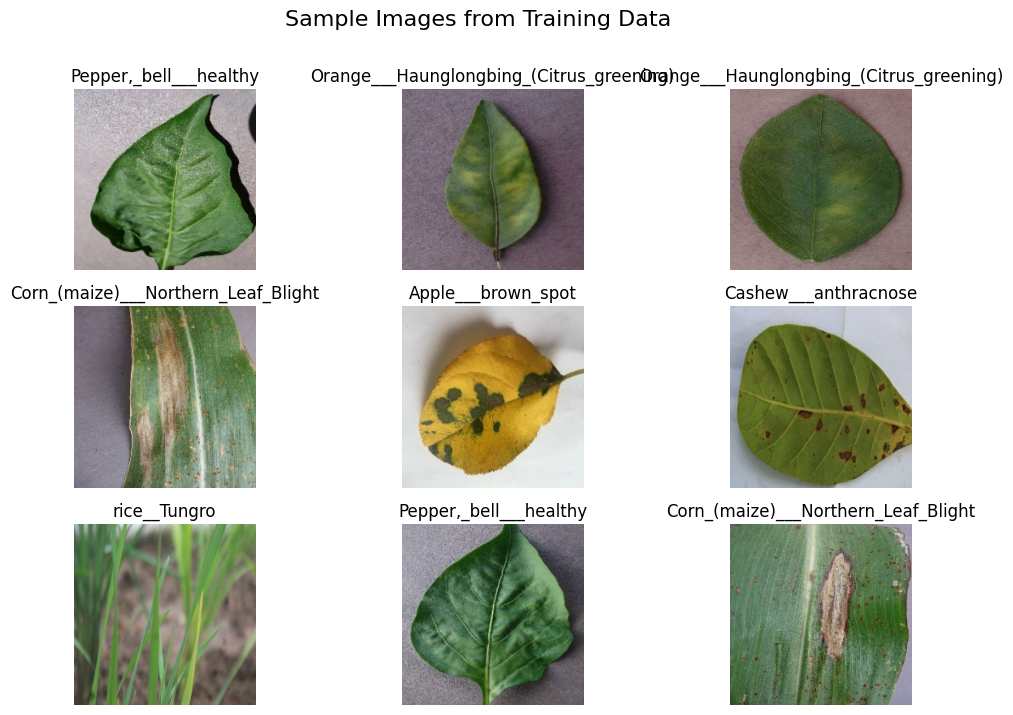

In [7]:
# Fetch a batch of images and labels from the training generator
plt.figure(figsize=(12, 8))
for images, labels in train_dataset.take(1):  # Take one batch
    for i in range(min(9, images.shape[0])):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = np.argmax(labels[i].numpy())
        plt.title(class_names[label_index])
        plt.axis("off")
plt.suptitle("Sample Images from Training Data", fontsize=16)
plt.show()

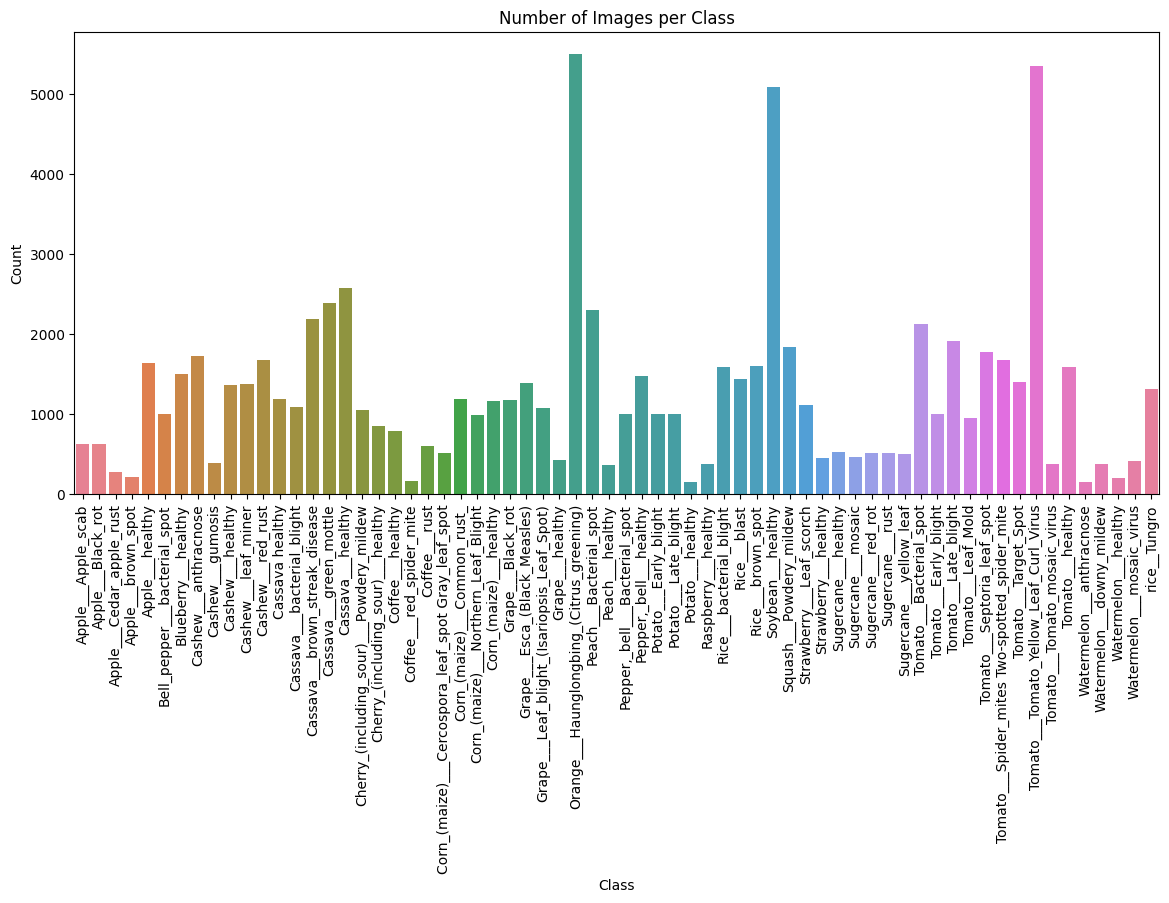

In [8]:

# Count images per class from the directory structure
import pandas as pd
class_counts = {}
for cls in class_names:
    path = os.path.join(DATA_DIR, cls)
    class_counts[cls] = len(os.listdir(path))

# Convert class names and counts to a DataFrame
df_class_counts = pd.DataFrame(
    {"Class": list(class_counts.keys()), "Count": list(class_counts.values())})

# Generate a color palette (one color per class)
colors = sns.color_palette("husl", len(class_counts))

# Create the barplot with correct hue usage
plt.figure(figsize=(14, 6))
sns.barplot(data=df_class_counts, x="Class", y="Count",
            hue="Class", palette=colors, dodge=False)
plt.title("Number of Images per Class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=90)
# Hide legend since colors are only for visualization
plt.legend([], [], frameon=False)
plt.show()

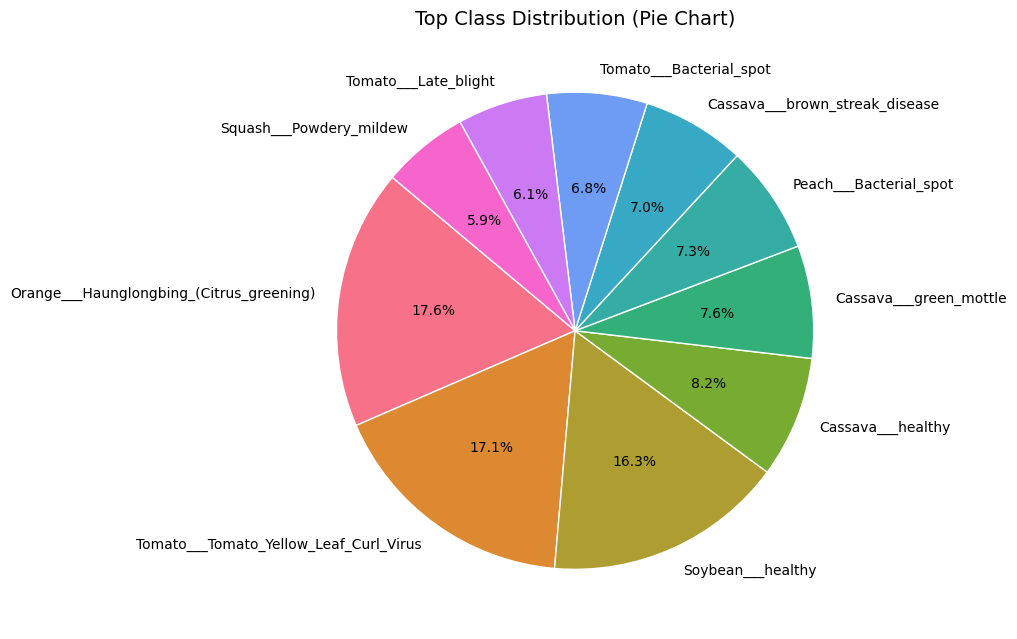

In [ ]:
# -------------------------------
# 3️⃣ Check Label Distribution (Pie Chart)
# -------------------------------
plt.figure(figsize=(10, 10))  # bigger figure
# Only show top classes to avoid overcrowding
top_n = 10  # or 15
top_classes = df_class_counts.sort_values(
    by="Count", ascending=False).head(top_n)

# Create the pie chart
plt.pie(
    top_classes["Count"],
    labels=top_classes["Class"],
    autopct="%1.1f%%",
    colors=sns.color_palette("husl", len(top_classes)),
    startangle=140,          # Rotate start angle for better layout
    wedgeprops={'edgecolor': 'white'},  # Add white edges
    textprops={'fontsize': 10}          # Smaller font to avoid overlapping
)

plt.title("Top Class Distribution (Pie Chart)", fontsize=14)
plt.tight_layout()
plt.show()

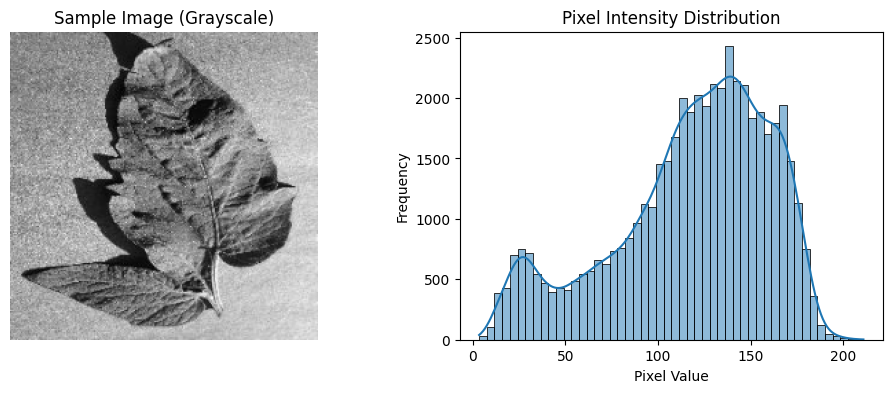

In [ ]:
# -------------------------------
# 5️⃣ Analyze Pixel Intensities
# -------------------------------
for images, _ in train_dataset.take(1):
    img = images[0].numpy().astype("uint8")
    gray_img = np.mean(img, axis=-1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(gray_img, cmap="gray")
    plt.title("Sample Image (Grayscale)")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    sns.histplot(gray_img.ravel(), bins=50, kde=True)
    plt.title("Pixel Intensity Distribution")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.show()

2025-04-07 07:49:29.543457: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
2025-04-07 07:49:32.413072: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


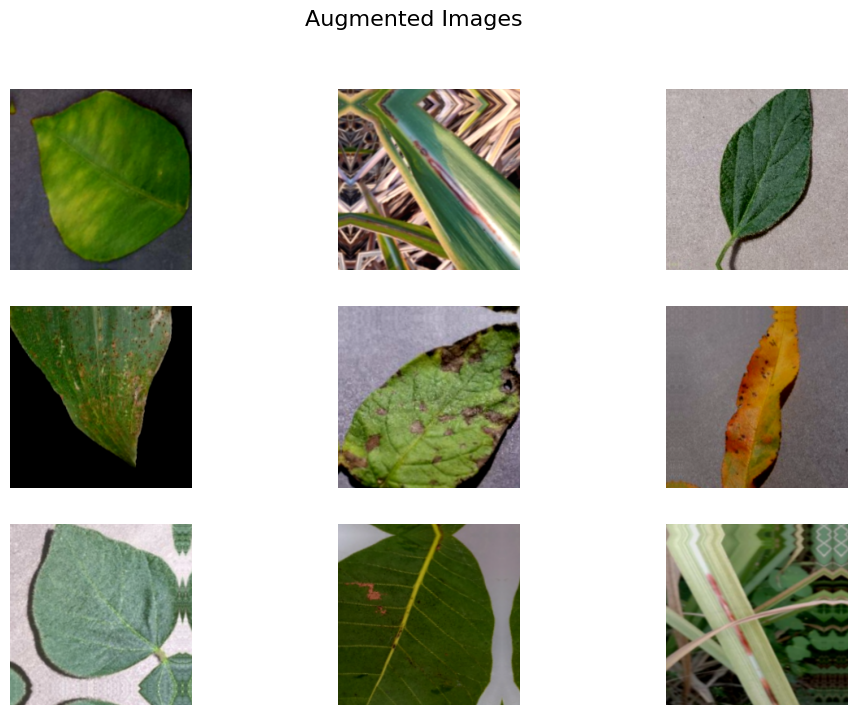

In [ ]:
# -------------------------------
# 7️⃣ Visualize Augmented Images
# -------------------------------

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),  # Flip horizontally
    tf.keras.layers.RandomRotation(0.2),  # Rotate by ±20%
    tf.keras.layers.RandomZoom(0.2),  # Zoom in/out by 20%
    tf.keras.layers.RandomContrast(0.2),  # Change contrast by ±20%
    tf.keras.layers.RandomBrightness(0.2),  # Adjust brightness randomly
    tf.keras.layers.RandomTranslation(
        height_factor=0.1, width_factor=0.1)  # Shift images slightly
])
plt.figure(figsize=(12, 8))
for images, _ in train_dataset.take(1):
    for i in range(min(9, images.shape[0])):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(images[i], 0))
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.axis("off")

plt.suptitle("Augmented Images", fontsize=16)
plt.show()

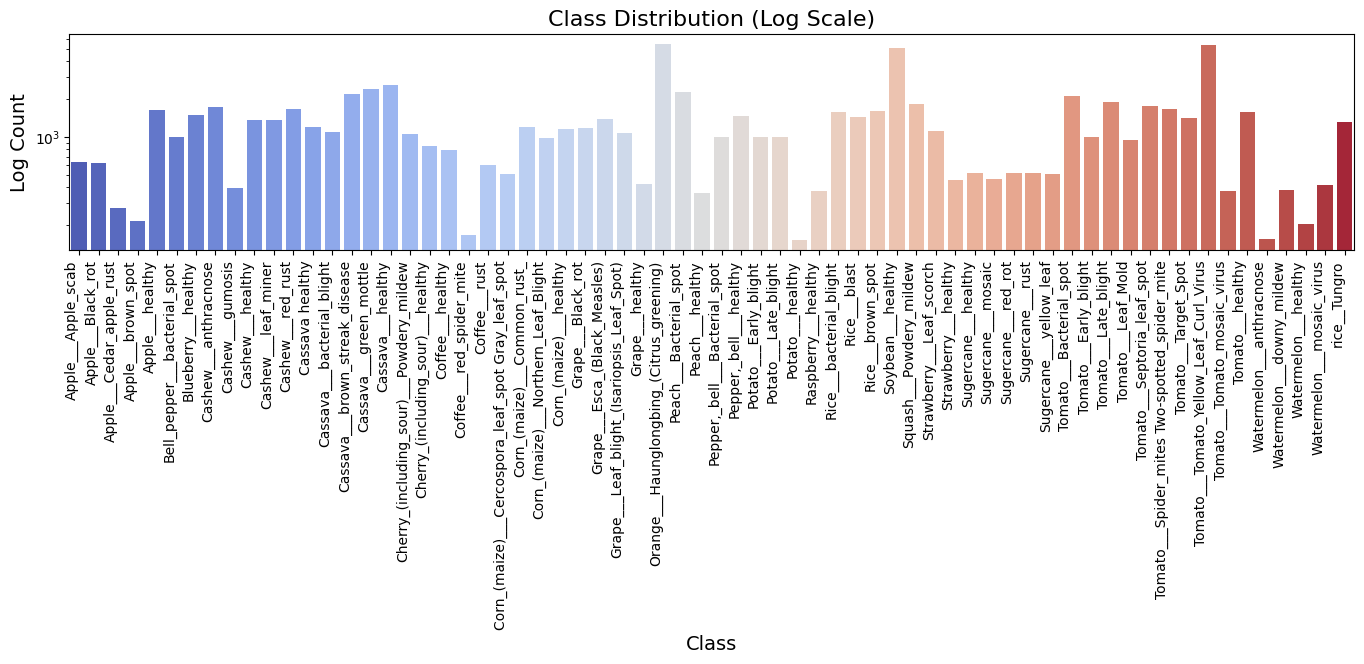

In [ ]:
# -------------------------------
# 9️⃣ Check Class Imbalance (Log Scale)
# -------------------------------
plt.figure(figsize=(14, 7))  # Bigger figure
sns.barplot(data=df_class_counts, x="Class", y="Count",
            hue="Class", legend=False, palette="coolwarm")
plt.yscale("log")
plt.title("Class Distribution (Log Scale)", fontsize=16)
plt.xlabel("Class", fontsize=14)
plt.ylabel("Log Count", fontsize=14)
plt.xticks(rotation=90, ha="right", fontsize=10)  # Rotate labels and align
plt.tight_layout(pad=2)  # Add extra padding
plt.show()

## 3. Data Preprocessing and Augmentation Explained

In this section, we detail the preprocessing steps:

- **Rescaling:** Normalize pixel values to [0, 1].
- **Data Augmentation:** We apply random rotations, shifts, shearing, zoom, and flips to increase dataset variability, which helps prevent overfitting.
- **Validation Preprocessing:** Only rescaling is applied for validation to get a consistent measure of performance.


In [14]:
# The preprocessing is integrated into our ImageDataGenerator setup above.
# The 'train_datagen' applies many random transformations to each image,
# increasing the effective size of our training dataset and making the model robust.

## **4. MODEL BUILDING (TRANSFER LEARNING WITH MOBILENETV2)**

We'll load the MobileNetV2 architecture (pre-trained on ImageNet), remove its top layers, and add a custom classification head for our dataset.

1. Freeze the base model's layers to retain pre-trained features.
2. Add global average pooling, dropout, and dense layers.
3. Compile the model with a chosen optimizer (Adam) and loss function (categorical crossentropy).


In [15]:
# Load MobileNetV2 without the top layers, with ImageNet weights
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model to retain pre-trained features
base_model.trainable = False

## 4.2 Build the Model

## Integrate data augmentation and build the full model.


In [16]:
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout

inputs = Input(shape=IMG_SIZE + (3,))
# Apply data augmentation
x = data_augmentation(inputs)
# Preprocess according to MobileNetV2 requirements
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
# Pass augmented images through the base model
x = base_model(x, training=False)
# Pool the features
x = GlobalAveragePooling2D()(x)
# Apply dropout for regularization
x = Dropout(0.2)(x)
# Final classification layer
outputs = Dense(len(class_names), activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

# Display model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 66)             │        84,546 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,342,530 (8.94 MB)

 Trainable params: 84,546 (330.26 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# 4.3 Compile the Model

`Use an optimizer with a learning rate scheduler.`


In [17]:
# Learning rate schedule
initial_lr = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=10000,
    decay_rate=0.9
)

# Optimizer with learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile the model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

<!-- 5. Model Training
5.1 Define Callbacks
Set up callbacks for early stopping, learning rate reduction, and saving the best model. -->


In [18]:
# Callbacks (Removed ReduceLROnPlateau)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("output/best_plantvillage_model.keras",
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1)

# **SECTION 5: TRAINING THE MODEL**

We now fit our model on the training data and validate it on the validation set. We also pass our callbacks to monitor and adjust the training process.


In [19]:
# Train the model
EPOCHS = 40
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint]  # Removed ReduceLROnPlateau
)

Epoch 1/40


I0000 00:00:1744012221.646593   18214 cuda_dnn.cc:529] Loaded cuDNN version 90300


1809/1809 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6381 - loss: 1.3352
Epoch 1: val_loss improved from inf to 0.45357, saving model to output/best_plantvillage_model.keras
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 99s 51ms/step - accuracy: 0.6382 - loss: 1.3349 - val_accuracy: 0.8435 - val_loss: 0.4536
Epoch 2/40
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8299 - loss: 0.4943
Epoch 2: val_loss improved from 0.45357 to 0.38313, saving model to output/best_plantvillage_model.keras
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 94s 52ms/step - accuracy: 0.8299 - loss: 0.4943 - val_accuracy: 0.8650 - val_loss: 0.3831
Epoch 3/40
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8440 - loss: 0.4490
Epoch 3: val_loss improved from 0.38313 to 0.36527, saving model to output/best_plantvillage_model.keras
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 95s 52ms/step - accuracy: 0.8440 - loss: 0.4490 - val_accuracy: 0.8721 - val_loss: 0.3653
Epoch 4/40
1808/1809 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8

## 6. Fine-Tuning the Model

After initial training, unfreeze part of the base model for fine-tuning.


In [20]:
# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Freeze the lower layers to preserve low-level features
for layer in base_model.layers[:100]:
    layer.trainable = False

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training for additional epochs
fine_tune_epochs = 20
total_epochs = EPOCHS + fine_tune_epochs

history_fine = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    callbacks=[early_stop,  checkpoint]
)

Epoch 24/60
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7112 - loss: 1.2199
Epoch 24: val_loss did not improve from 0.30941
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 142s 71ms/step - accuracy: 0.7112 - loss: 1.2197 - val_accuracy: 0.8736 - val_loss: 0.3620
Epoch 25/60
1808/1809 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8540 - loss: 0.4121
Epoch 25: val_loss did not improve from 0.30941
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 128s 70ms/step - accuracy: 0.8540 - loss: 0.4120 - val_accuracy: 0.8860 - val_loss: 0.3149
Epoch 26/60
1808/1809 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8749 - loss: 0.3403
Epoch 26: val_loss improved from 0.30941 to 0.28446, saving model to output/best_plantvillage_model.keras
1809/1809 ━━━━━━━━━━━━━━━━━━━━ 128s 71ms/step - accuracy: 0.8749 - loss: 0.3403 - val_accuracy: 0.8947 - val_loss: 0.2845
Epoch 27/60
1808/1809 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8853 - loss: 0.3016
Epoch 27: val_loss improved from 0.28446 to 0.26061, saving model to out

## 7. Evaluation and Visualization

7.1 Plot Training History


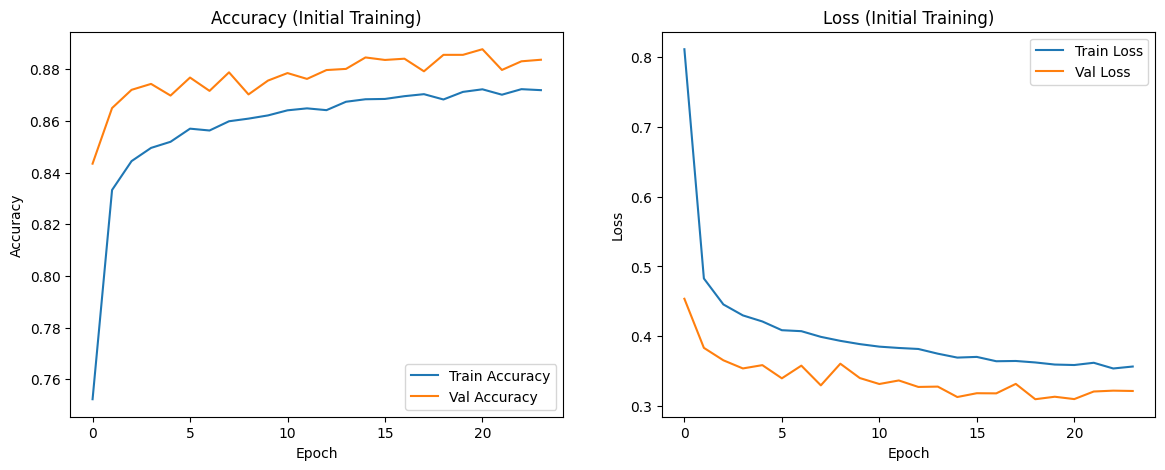

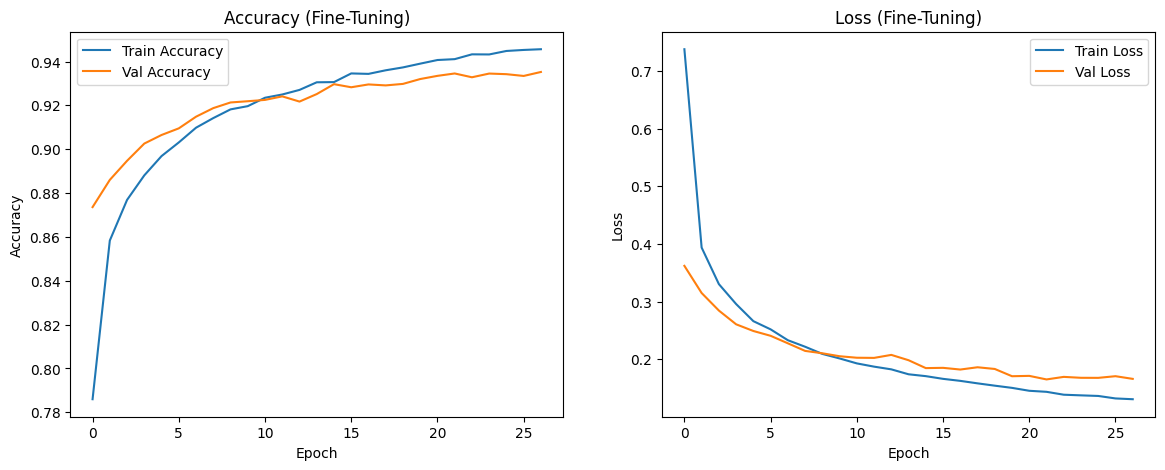

In [21]:
def plot_history(hist, title_suffix=""):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'], label='Train Accuracy')
    plt.plot(hist.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy' + title_suffix)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.title('Loss' + title_suffix)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


# Plot initial training history
plot_history(history, " (Initial Training)")
# Plot fine-tuning history if applicable
plot_history(history_fine, " (Fine-Tuning)")

7.2 Confusion Matrix and Classification Report


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━

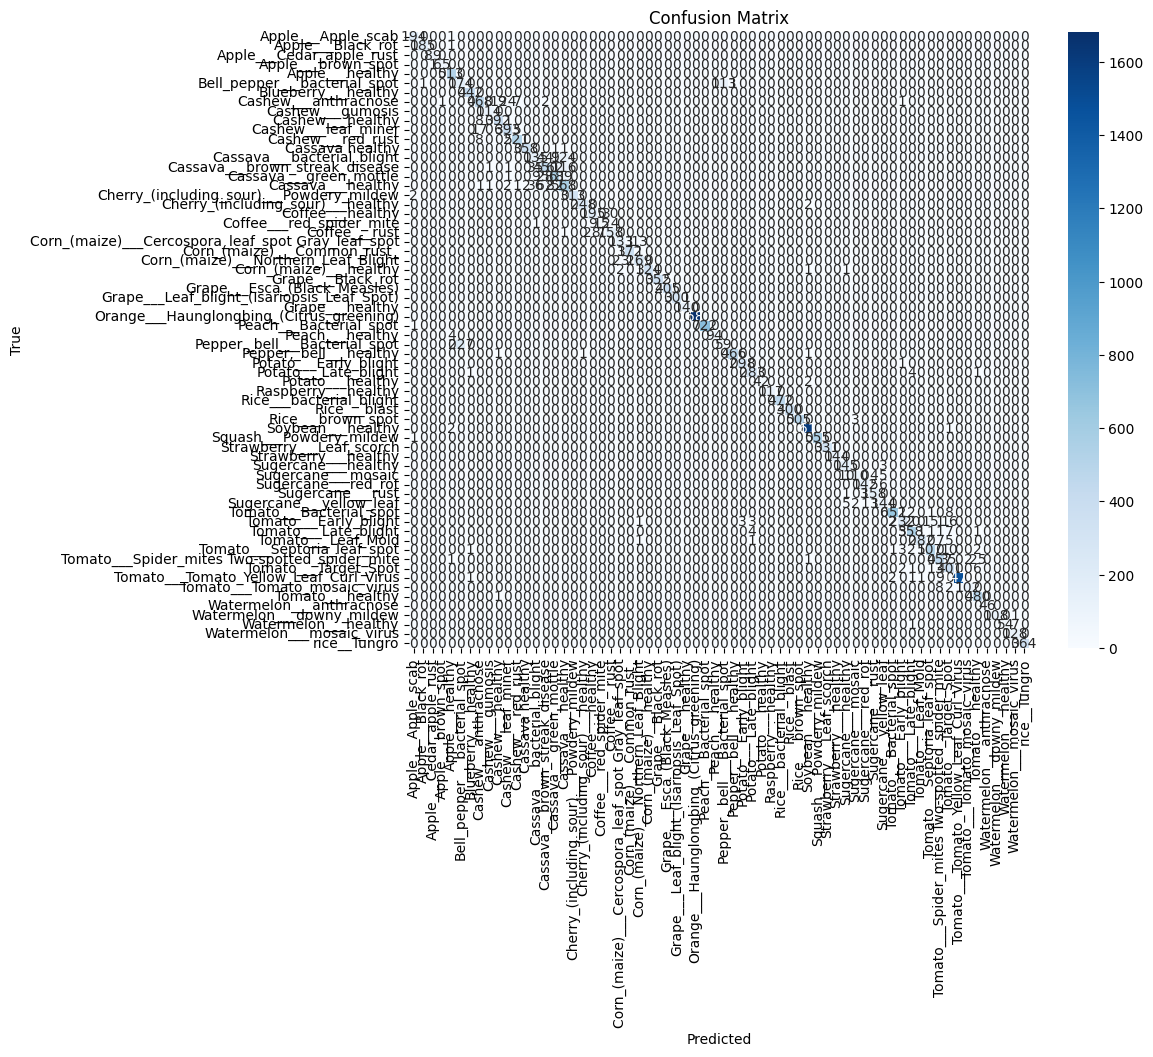

Classification Report:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.98      0.99      0.99       195
                                 Apple___Black_rot       0.99      0.99      0.99       186
                          Apple___Cedar_apple_rust       0.99      1.00      0.99        89
                                Apple___brown_spot       0.98      0.98      0.98        66
                                   Apple___healthy       0.98      1.00      0.99       513
                      Bell_pepper___bacterial_spot       0.43      0.60      0.50       289
                               Blueberry___healthy       0.99      1.00      1.00       442
                              Cashew___anthracnose       0.93      0.90      0.91       522
                                  Cashew___gumosis       0.98      1.00      0.99       114
                                  Cashew___healthy     

In [22]:
# Get predictions for the validation set
y_true = []
y_pred = []

for images, labels in validation_dataset:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))